# CVE- Common Vulnerabilities and Exposures
cve data extracted into MongoDB using cve-search - https://github.com/cve-search/cve-search

* The extracted data from MongoDB is analyzed in this notebook

## Importing Libraries

In [1]:
#Basic Libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
import string
import re

#Tensorflow, sklearn and nltk
import tensorflow as tf
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
#!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import GlobalAvgPool1D, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
#!pip install tensorflow-addons
#import tensorflow_addons as tfa

#WordCloud
from wordcloud import WordCloud

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Spacy
import spacy

#Vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

#warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connecting to MongoDB

In [2]:
# importing the required libraries
import pymongo
import pprint
import json

# connect to the mongoclient
client = pymongo.MongoClient('mongodb://localhost:27017')

# get the database
db = client['cvedb']

collection = db.get_collection('cves')

## Loading Data

In [4]:
import pandas as pd

cursor = collection.find()

allitems_df = pd.DataFrame(list(cursor))
#allitems_df.to_csv('pymongo-allitems.csv')
allitems_df.head(5)

,_id,id,assigner,Published,Modified,last-modified,summary,access,impact,cvss3,...,products,vulnerable_product_stems,vulnerable_configuration_stems,cwe,vulnerable_configuration_cpe_2_2,impact3,exploitability3,cvss3-vector,impactScore3,exploitabilityScore3
0,6211d7cc1291c8f278e33ed1,CVE-1999-0006,cve@mitre.org,1998-07-14 04:00:00,2008-09-09 12:33:00,2008-09-09 12:33:00,Buffer overflow in POP servers based on BSD/Qu...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'COMPLETE', 'confidentiality'...",NaN,...,[qpopper],[cpe:2.3:a:qualcomm:qpopper],[cpe:2.3:a:qualcomm:qpopper],NVD-CWE-Other,[],NaN,NaN,NaN,NaN,NaN
1,6211d7cc1291c8f278e33ed2,CVE-2003-0011,cve@mitre.org,2003-03-24 05:00:00,2018-10-12 21:32:00,2018-10-12 21:32:00,Unknown vulnerability in the DNS intrusion det...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",NaN,...,[isa_server],[cpe:2.3:a:microsoft:isa_server],[cpe:2.3:a:microsoft:isa_server],NVD-CWE-Other,[],NaN,NaN,NaN,NaN,NaN
2,6211d7cc1291c8f278e33ed3,CVE-2008-0001,secalert@redhat.com,2008-01-15 20:00:00,2018-10-15 21:56:00,2018-10-15 21:56:00,"VFS in the Linux kernel before 2.6.22.16, and ...","{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",NaN,...,[linux_kernel],[cpe:2.3:o:linux:linux_kernel],[cpe:2.3:o:linux:linux_kernel],NVD-CWE-Other,[],NaN,NaN,NaN,NaN,NaN
3,6211d7cc1291c8f278e33ed4,CVE-2003-0013,cve@mitre.org,2003-01-17 05:00:00,2016-10-18 02:28:00,2016-10-18 02:28:00,The default .htaccess scripts for Bugzilla 2.1...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",NaN,...,[bugzilla],[cpe:2.3:a:mozilla:bugzilla],[cpe:2.3:a:mozilla:bugzilla],NVD-CWE-Other,[],NaN,NaN,NaN,NaN,NaN
4,6211d7cc1291c8f278e33ed5,CVE-2004-0009,cve@mitre.org,2004-03-03 05:00:00,2017-10-10 01:30:00,2017-10-10 01:30:00,"Apache-SSL 1.3.28+1.52 and earlier, with SSLVe...","{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",NaN,...,[apache-ssl],[cpe:2.3:a:apache-ssl:apache-ssl],[cpe:2.3:a:apache-ssl:apache-ssl],NVD-CWE-Other,[],NaN,NaN,NaN,NaN,NaN


## Data Cleaning and Validation

In [5]:
allitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180964 entries, 0 to 180963
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   _id                               180964 non-null  object        
 1   id                                180964 non-null  object        
 2   assigner                          180964 non-null  object        
 3   Published                         180964 non-null  datetime64[ns]
 4   Modified                          180964 non-null  datetime64[ns]
 5   last-modified                     180964 non-null  datetime64[ns]
 6   summary                           180964 non-null  object        
 7   access                            180964 non-null  object        
 8   impact                            180964 non-null  object        
 9   cvss3                             96453 non-null   float64       
 10  cvss                            

In [6]:
allitems_df.isna().sum()

_id                                     0
id                                      0
assigner                                0
Published                               0
Modified                                0
last-modified                           0
summary                                 0
access                                  0
impact                                  0
cvss3                               84511
cvss                                11166
exploitabilityScore                 11166
impactScore                         11166
cvss-time                           11166
cvss-vector                         11166
references                              0
vulnerable_configuration                0
vulnerable_product                      0
vendors                                 0
products                                0
vulnerable_product_stems                0
vulnerable_configuration_stems          0
cwe                                     0
vulnerable_configuration_cpe_2_2  

In [7]:
# Checking if duplicates are there by cve_id (id column)
print(~len(allitems_df.id.drop_duplicates())==len(allitems_df))
print("So, there are no duplicate columns")

False
So, there are no duplicate columns


In [8]:
# Checking if both columns are one and the same
print((allitems_df['last-modified']==allitems_df['Modified']).all())
print("So, Last modified and modified are basically same columns indicating the latest date the cve record got updated")

True
So, Last modified and modified are basically same columns indicating the latest date the cve record got updated


In [9]:
#Sample values of column impact
allitems_df.impact.sample(5).values

array([{'availability': 'NONE', 'confidentiality': 'NONE', 'integrity': 'PARTIAL'},
       {'availability': 'PARTIAL', 'confidentiality': 'NONE', 'integrity': 'NONE'},
       {'availability': 'PARTIAL', 'confidentiality': 'PARTIAL', 'integrity': 'PARTIAL'},
       {'availability': 'PARTIAL', 'confidentiality': 'PARTIAL', 'integrity': 'PARTIAL'},
       {'availability': 'PARTIAL', 'confidentiality': 'PARTIAL', 'integrity': 'PARTIAL'}],
      dtype=object)

In [10]:
#Sample values of column access
allitems_df.access.sample(5).values

array([{'authentication': 'SINGLE', 'complexity': 'LOW', 'vector': 'NETWORK'},
       {'authentication': 'NONE', 'complexity': 'LOW', 'vector': 'NETWORK'},
       {'authentication': 'NONE', 'complexity': 'LOW', 'vector': 'LOCAL'},
       {'authentication': 'SINGLE', 'complexity': 'LOW', 'vector': 'NETWORK'},
       {'authentication': 'NONE', 'complexity': 'LOW', 'vector': 'NETWORK'}],
      dtype=object)

In [11]:
allitems_df = allitems_df.iloc[allitems_df.vendors.str[0].dropna().index,:].reset_index().copy()

## EDA

### Products

Number of records corresponding to products more than one:	 43501


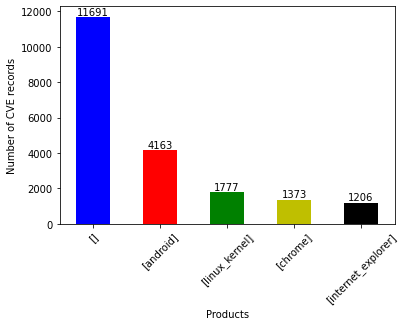

In [10]:
c=0
for i in range(len(allitems_df)):
    if len(allitems_df.products[i])>1:
        #print(allitems_df.vendors[i])
        c+=1

print("Number of records corresponding to products more than one:\t",c)

p = allitems_df.products.value_counts()[:5]

def plot_bar(p, my_colors=list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(p))) ):
    ax = p.plot.bar(color=my_colors)
    for container in ax.containers:
        ax.bar_label(container)
    return ax

ax = plot_bar(p)
plt.xlabel('Products')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()

### Vendors

Number of records relating to vendors more than one:	 15144


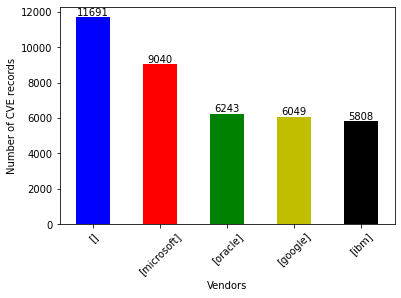

In [11]:
c=0
for i in range(len(allitems_df)):
    if len(allitems_df.vendors[i])>1:
        #print(allitems_df.vendors[i])
        c+=1

print("Number of records relating to vendors more than one:\t",c)

p = allitems_df.vendors.value_counts()[:5]
ax = plot_bar(p)
plt.xlabel('Vendors')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()

### Assigners

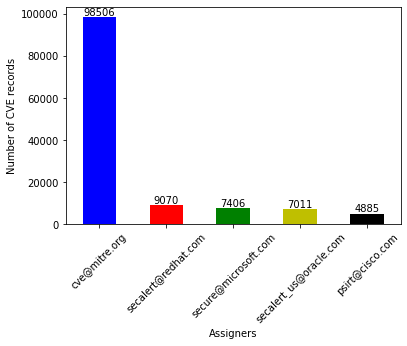

Total number of unique assigners of cve records available:	 186


In [12]:
p = allitems_df.assigner.value_counts()[:5]

ax = plot_bar(p)
plt.xlabel('Assigners')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()
    
print("Total number of unique assigners of cve records available:\t",len(allitems_df.assigner.unique()))

### Summary or description of the CVE in Wordcloud

Maximum summary/description of a cve record available is 3819


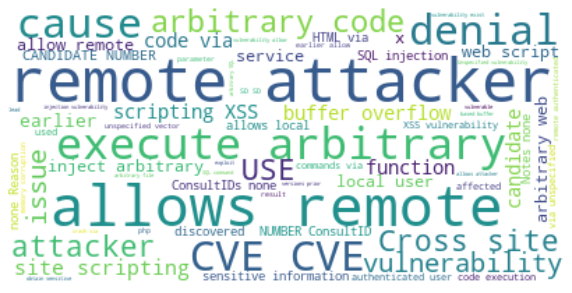

In [55]:
print('Maximum summary/description of a cve record available is',\
      np.vectorize(len)(allitems_df.summary.values.astype(str)).max(axis=0))

def word_cloud(text,
               max_font_size=50,
               max_words=100,
               background_color='white', 
               figsize=(10,10),  
               interpolation="bilinear"):
    wc = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

text = ' '.join(allitems_df.summary.values)
word_cloud(text)

## Data Preparation

In [12]:
# Selecting a particular vendor ex. cisco
cisco_df = allitems_df.loc[allitems_df.vendors.str[0].str.contains("cisco"), :].reset_index()

In [13]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(cisco_df.summary)
print (lemmatized_texts[0][0:90])

heap base buffer overflow service CUCM allow remote attacker cause denial service execute 


In [14]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['heap', 'base', 'buffer', 'overflow', 'service', 'cucm', 'allow', 'remote', 'attacker', 'cause', 'denial', 'service', 'execute', 'arbitrary', 'code', 'long', 'request']


In [15]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (new[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2)]
allow


In [34]:
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]
id_words

[[('allow', 1),
  ('arbitrary', 1),
  ('attacker', 1),
  ('base', 1),
  ('buffer', 1),
  ('cause', 1),
  ('code', 1),
  ('cucm', 1),
  ('denial', 1),
  ('execute', 1),
  ('heap', 1),
  ('long', 1),
  ('overflow', 1),
  ('remote', 1),
  ('request', 1),
  ('service', 2)],
 [('allow', 1),
  ('attacker', 1),
  ('cause', 1),
  ('denial', 1),
  ('remote', 1),
  ('service', 1),
  ('craft', 1),
  ('decrement', 1),
  ('device', 1),
  ('enable', 1),
  ('feature', 1),
  ('live', 1),
  ('packet', 1),
  ('reload', 1),
  ('time', 1),
  ('unspecified', 1),
  ('vulnerability', 1)],
 [('allow', 1),
  ('attacker', 1),
  ('connect', 1),
  ('file', 1),
  ('firewall', 1),
  ('know', 1),
  ('location', 1),
  ('manager', 1),
  ('name', 1),
  ('pfm', 1),
  ('port', 1),
  ('retrieve', 1),
  ('server', 1)],
 [('allow', 1),
  ('attacker', 1),
  ('execute', 1),
  ('aaa', 1),
  ('authentication', 1),
  ('authorization', 1),
  ('command', 1),
  ('system', 1)],
 [('allow', 1),
  ('attacker', 1),
  ('cause', 1),
  ('

In [26]:
data_words

[['heap',
  'base',
  'buffer',
  'overflow',
  'service',
  'cucm',
  'allow',
  'remote',
  'attacker',
  'cause',
  'denial',
  'service',
  'execute',
  'arbitrary',
  'code',
  'long',
  'request'],
 ['unspecified',
  'vulnerability',
  'time',
  'live',
  'decrement',
  'feature',
  'enable',
  'allow',
  'remote',
  'attacker',
  'cause',
  'denial',
  'service',
  'device',
  'reload',
  'craft',
  'packet'],
 ['firewall',
  'manager',
  'allow',
  'attacker',
  'connect',
  'port',
  'pfm',
  'server',
  'retrieve',
  'file',
  'name',
  'location',
  'know'],
 ['aaa',
  'authentication',
  'system',
  'allow',
  'attacker',
  'execute',
  'command',
  'authorization'],
 ['service',
  'allow',
  'remote',
  'attacker',
  'cause',
  'denial',
  'service',
  'voice',
  'service',
  'outage',
  'send',
  'malformed',
  'input',
  'session',
  'client',
  'terminate',
  'prematurely'],
 ['allow',
  'remote',
  'attacker',
  'bypass',
  'authentication',
  'download',
  'arbitrary'

In [25]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 2)],
 [(0, 1),
  (2, 1),
  (5, 1),
  (8, 1),
  (13, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(0, 1),
  (2, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(0, 1), (2, 1), (9, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)],
 [(0, 1),
  (2, 1),
  (5, 1),
  (8, 1),
  (13, 1),
  (15, 3),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (13, 1),
  (14, 1),
  (28, 1),
  (39, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1)],
 [(2, 1),
  (18, 1),
  (66, 1),
  (67, 1),
 

## LDA Model

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=10,
                                           chunksize=1000,
                                           passes=50,
                                           iterations = 100,
                                           alpha="auto")

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.028482  0.180170       1        1  55.287769
0      0.135061 -0.190592       2        1  27.054247
2     -0.163544  0.010422       3        1  17.657984, topic_info=              Term         Freq        Total Category  logprob  loglift
5            cause  2774.000000  2774.000000  Default  30.0000  30.0000
15         service  2376.000000  2376.000000  Default  29.0000  29.0000
880        exploit  4711.000000  4711.000000  Default  28.0000  28.0000
8           denial  1953.000000  1953.000000  Default  27.0000  27.0000
875       affected  4381.000000  4381.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
26   vulnerability   707.799983  8968.900916   Topic3  -3.8036  -0.8054
9          execute   339.699159  1903.864758   Topic3  -4.5377   0.0104
94     information   274.363777  1391.624578   Topic3  -4.7513   0.1102
167          local   241.211900   836.121462   Topic3  -4.8801   0.4909
126      interface   244.108529  2596.781581   Topic3  -4.8682  -0.6304

[225 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
105       1  0.744199          access
105       2  0.020189          access
105       3  0.235303          access
150       3  0.972835  administration
946       1  0.984771        advisory
...     ...       ...             ...
166       1  0.730747             web
166       3  0.269283             web
294       3  0.940965        web_link
972       1  0.029343         website
972       3  0.968330         website

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [18]:
lda_model.print_topics()

[(0,
  '0.048*"attacker" + 0.046*"allow" + 0.041*"cause" + 0.040*"device" + 0.038*"remote" + 0.034*"service" + 0.030*"denial" + 0.027*"aka" + 0.021*"packet" + 0.018*"vulnerability"'),
 (1,
  '0.068*"vulnerability" + 0.059*"attacker" + 0.041*"allow" + 0.038*"exploit" + 0.035*"affected" + 0.026*"user" + 0.023*"web" + 0.022*"interface" + 0.021*"device" + 0.021*"arbitrary"')]

In [20]:
print("\nPerplexity:\t",lda_model.log_perplexity(corpus, total_docs=10000),'\n')

coherence_model_lda = CoherenceModel(model=lda_model, texts=cisco_df.summary, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score:\t",coherence_lda,'\n')


Perplexity:	 -5.259291944963844 


Coherence Score:	 nan 

